<h3>Мошшенические транзакции</h3>

В этом ноутбуке мы рассмотрим задачу детектирования мошеннических транзакций на основе синтетического датасета FraudSynth: Credit Fraud Detection Dataset (https://www.kaggle.com/datasets/youssefismail20/fraudsynth-credit-fraud-detection-dataset). Наша цель — изучить структуру данных, выявить закономерности, а также построить и оценить качество моделей машинного обучения для классификации транзакций на мошеннические и обычные.

В ходе анализа мы:

- Изучим распределения признаков и визуализируем зависимости между ними
- Проверим датасет на полноту и уникальность данных
- Обучим модель, определим важнейшие признаки и оценим точность работы алгоритма

Данный проект позволяет продемонстрировать полный цикл подготовки и анализа данных, включая построение модели и интерпретацию результатов на синтетическом примере.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('fraud.csv')

In [4]:
data.head()

,timestamp,user_id,amount,location,device_type,is_fraud,age,income,debt,credit_score
0,2023-12-15 02:48:24,3cbf0b8a-c799-4c0e-9782-89272ab8fa2b,998.99,Grantfurt,Mobile,0,56,42524.98,8394.05,655
1,2023-10-30 11:08:37,3675ed98-6863-4bae-b089-6f0db2df006b,241.39,Kimberlychester,Tablet,0,52,69884.04,28434.06,395
2,2023-11-21 05:19:35,4be1043f-20ee-4ac5-a689-b25c6a1de50c,836.42,Gutierrezville,Desktop,0,58,126953.62,39121.78,496
3,2023-11-07 00:03:25,cad0b3c9-099f-479b-8043-6d5ecb4e1467,612.74,Markside,Desktop,0,19,128650.70,39652.48,612
4,2023-04-02 14:12:23,b6ebea7d-ba62-41d7-b042-3978a23fef8b,135.55,Anthonyshire,Tablet,0,59,102020.39,7439.81,302


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   timestamp     object 
 1   user_id       object 
 2   amount        float64
 3   location      object 
 4   device_type   object 
 5   is_fraud      int64  
 6   age           int64  
 7   income        float64
 8   debt          float64
 9   credit_score  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 152.6+ MB


In [6]:
def feature_analysis(data, feature):
    print('Признак', feature)
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Минимальное значение: {min(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Среднее значение: {np.mean(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Максимальное значение: {max(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Медиана: {np.median(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Ассиметрия: {stats.skew(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Дисперсия: {np.var(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')
    print(f'Эксцесс: {stats.kurtosis(data[feature])}')
    print('#=#=#=#=#=#=#=#=#=#')

In [7]:
def hist_visual(data, feature):
    sns.set(style='whitegrid')
    palette = sns.color_palette(['#FF8C00', '#8A2BE2'])
    plt.figure(figsize=(10,6))
    data[feature].hist(bins=20, color=palette[1], alpha=0.7)
    mean = data[feature].mean()
    median = data[feature].median()
    plt.axvline(mean, color='orange', linestyle='dashed', linewidth=2, label='Среднее')
    plt.axvline(median, color='yellow', linestyle='dashed', linewidth=2, label='Медиана')
    plt.title(f'Гистограмма для {feature}', fontsize=14)
    plt.legend()
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Частота", fontsize=12)
    plt.tight_layout()
    plt.show()

In [8]:
def fog(data, feature, target='is_fraud'):
    target_0 = data[data[target] == 0][feature]
    target_1 = data[data[target] == 1][feature]
    sns.set_theme(style='whitegrid')

    plt.figure(figsize=(10,6))
    sns.histplot(target_0, kde=True, color='#9467bd', alpha=0.6, bins=30, label=f'{target} = 0')
    sns.histplot(target_1, kde=True, color='#ff7f0e', alpha=0.6, bins=30, label=f'{target} = 1')

    plt.title(f'Распределение {feature} по {target}', fontsize=16, fontweight='bold')
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.show()

In [9]:
def scatter_visual(data, x, y):
    sns.set(style='whitegrid')
    fig, axs = plt.subplots(figsize=(10,6))
    fig.suptitle('Влияние на целевую переменную', fontsize=18)
    axs.set_title(f'Зависимость {x} от {y}', fontsize=14)
    palette = sns.color_palette(['#FF8C00', '#8A2BE2'])
    sns.scatterplot(data=data, x=x, y=y, ax=axs, color=palette[1])
    axs.grid(True, linestyle='--', alpha=0.65)
    axs.set_xlabel(x)
    axs.set_ylabel(y)
    plt.show()

In [10]:
def scatter_with_outcome(data, feature_x, feature_y, target='is_fraud'):
    plt.figure(figsize=(10, 6))
    
    colors = data[target].map({0: 'purple', 1: 'orange'})
    
    plt.scatter(data[feature_x], data[feature_y], c=colors, alpha=0.5, sizes=(25, 300))
    
    plt.title(f'Диаграмма рассеивания: {feature_x} & {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    
    plt.show()

In [11]:
def anomaly(data, feature):
    q1 = np.quantile(data[feature], 0.25)
    q3 = np.quantile(data[feature], 0.75)
    IQR = q3 - q1
    lower = q1 - 1.5 * IQR
    upper = q3 + 1.5 * IQR
    print(f'Аномальные значения: {data[(data[feature] > upper) | (data[feature] < lower)][feature].count()}')
    print(data[(data[feature] > upper) | (data[feature] < lower)][feature])
    return data[(data[feature] > upper) | (data[feature] < lower)][feature]

In [12]:
def boxplot_visual(data, x, y, hue='is_fraud'):
    sns.set(style="darkgrid")

    plt.figure(figsize=(10, 6))
    box_plot = sns.boxplot(
        x=x,
        y=y,
        hue=hue,
        data=data,
        palette='muted'
    )

    plt.title(f'Распределение по {x} в зависимости от {y} и {hue}', fontsize=16)
    plt.xlabel(f'{x}', fontsize=14)
    plt.ylabel(f'{y}', fontsize=14)

    plt.show()

<h3>Анализ данных</h3>

In [14]:
explore = data.sample(frac=0.025, random_state=42)
explore.head()

,timestamp,user_id,amount,location,device_type,is_fraud,age,income,debt,credit_score
1828401,2023-08-10 19:45:13,88e4edff-70ec-48e2-98fc-e2158bda39ce,2820.81,East Ginashire,Desktop,1,61,109941.13,26723.01,445
1200071,2023-04-24 18:48:52,d0b2cf73-ae9c-427a-b91b-154868254738,3074.92,Lake Michelehaven,Mobile,1,52,77270.96,4145.25,320
194849,2023-09-11 22:09:37,53bcc7b9-4c8f-4c69-adf6-a6888431b7ba,176.97,West Sandrafurt,Desktop,0,26,127563.16,11420.89,397
1629054,2023-11-26 13:43:40,f623ca05-ec15-400d-b85d-9dcb99d6677e,3528.71,Randallbury,Desktop,1,47,124594.27,18794.04,819
191144,2023-12-06 05:50:28,16d63788-6ef5-49ac-81f6-cda2e182043f,629.59,Port Casey,Desktop,0,19,139644.01,3172.29,573


In [15]:
explore.shape

(50000, 10)

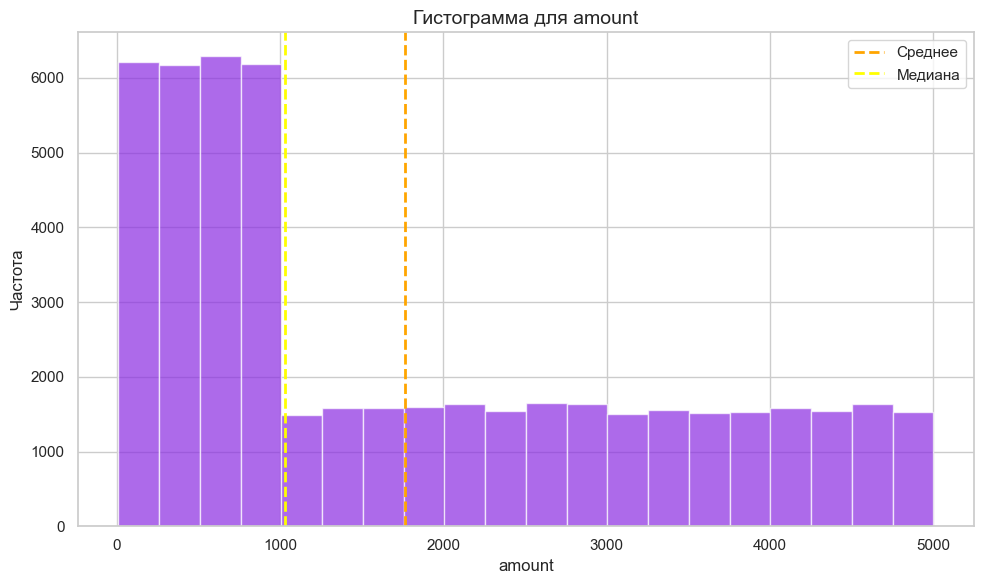

In [16]:
hist_visual(explore, 'amount')

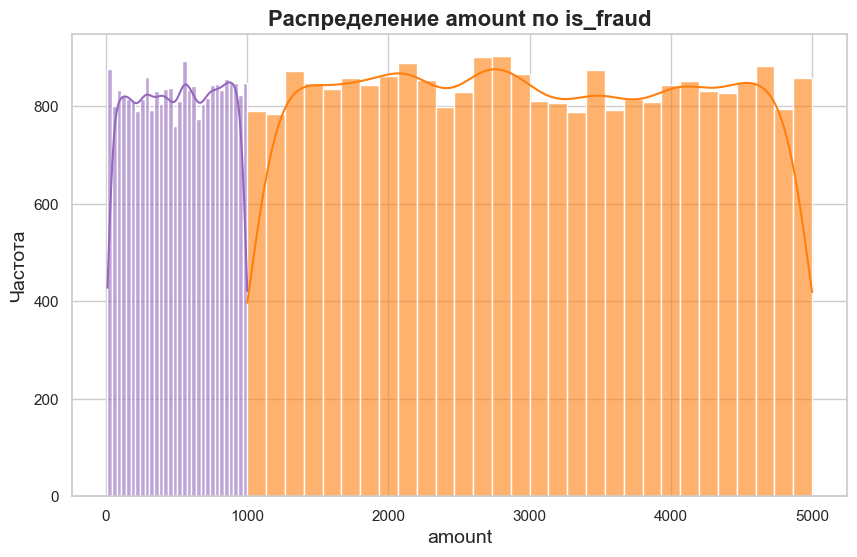

In [17]:
fog(explore, 'amount')

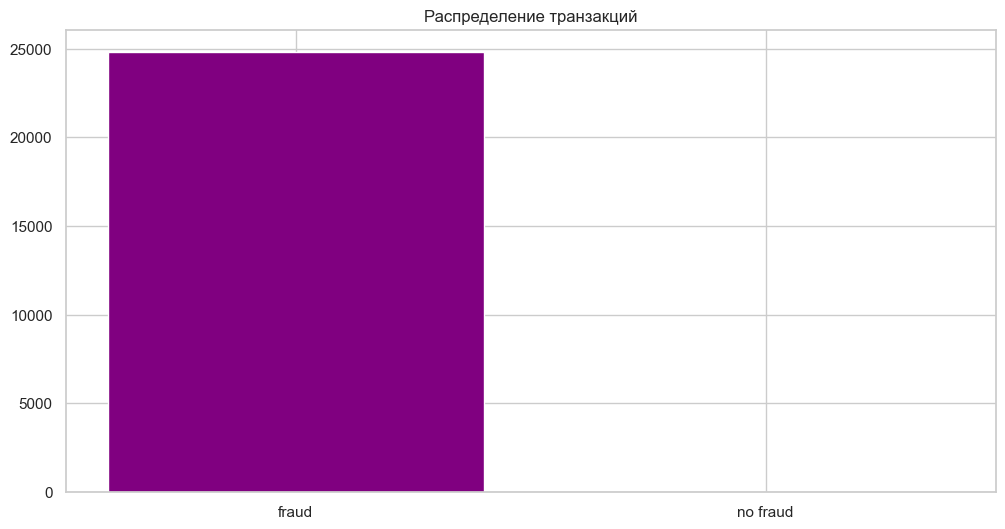

In [18]:
filtered_df_1 = explore[explore['amount'] <= 1000]
count_fraud_1 = filtered_df_1[filtered_df_1['is_fraud'] == 1].shape[0]
count_fraud_0 = filtered_df_1[filtered_df_1['is_fraud'] == 0].shape[0]
outcomes = [count_fraud_0, count_fraud_1]
labels = ['fraud', 'no fraud']

plt.figure(figsize=(12, 6))
plt.bar(labels, outcomes, color=['purple', 'orange'])
plt.title('Распределение транзакций')
plt.show()

In [19]:
explore[(explore['amount'] < 1000) & (explore['is_fraud'] == 1)]

,timestamp,user_id,amount,location,device_type,is_fraud,age,income,debt,credit_score


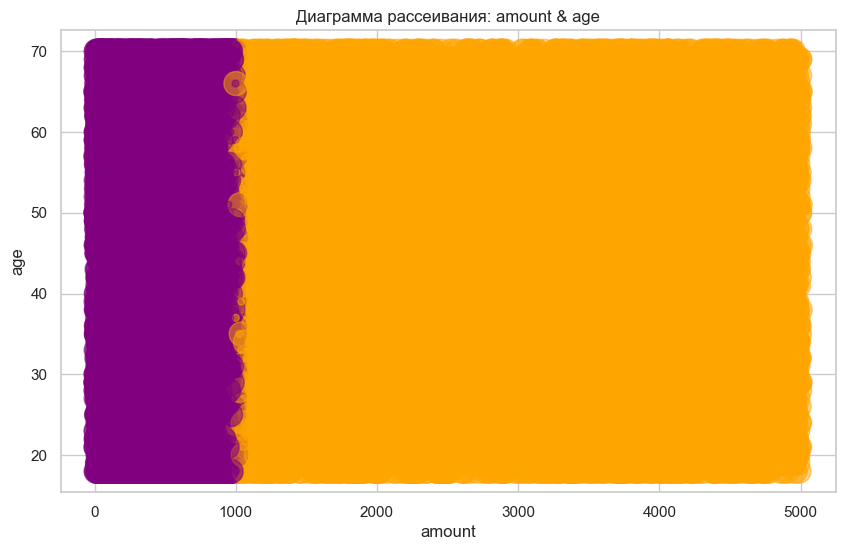

In [20]:
scatter_with_outcome(explore, 'amount', 'age')

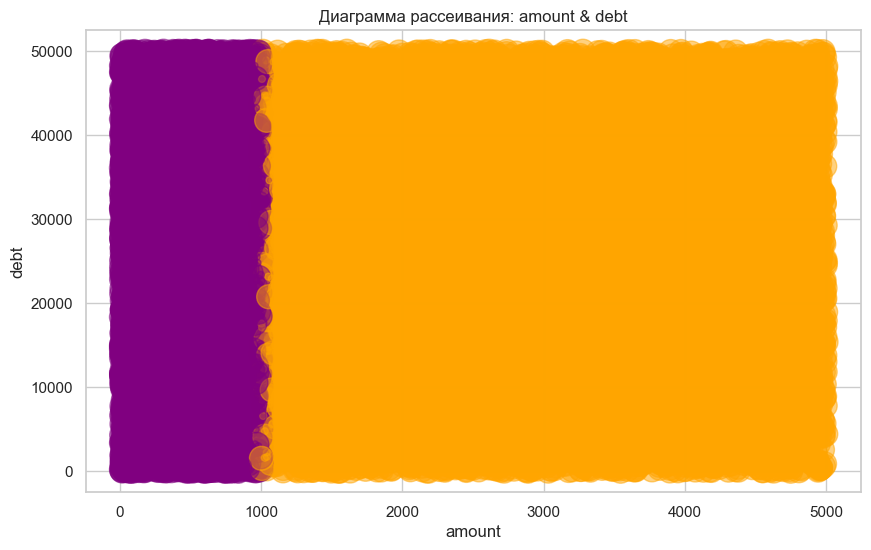

In [21]:
scatter_with_outcome(explore, 'amount', 'debt')

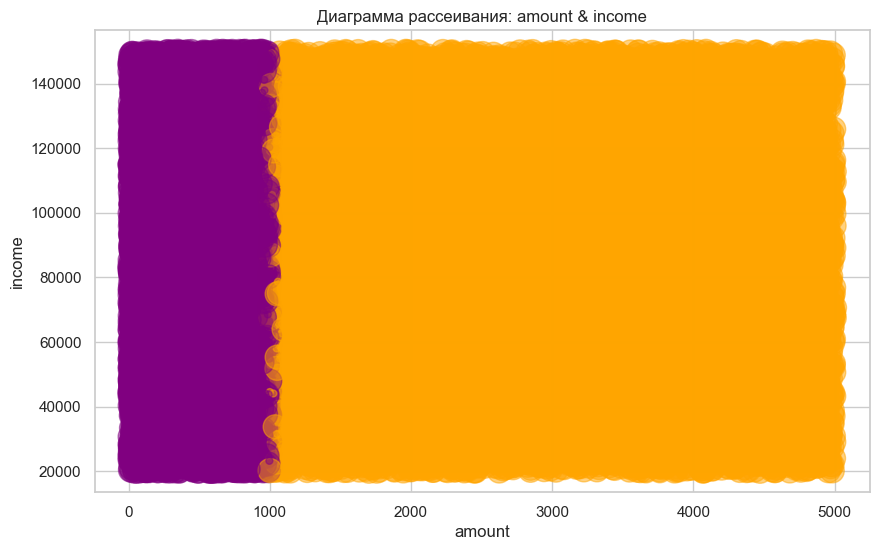

In [22]:
scatter_with_outcome(explore, 'amount', 'income')

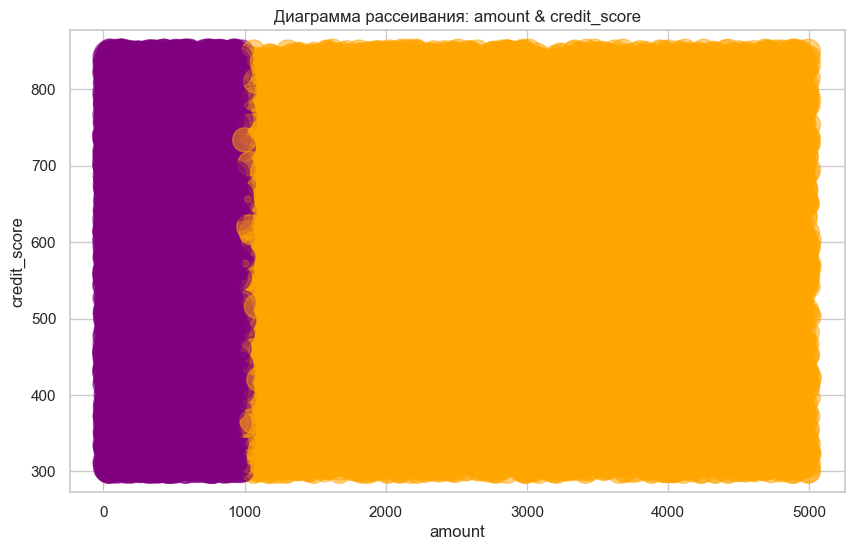

In [23]:
scatter_with_outcome(explore, 'amount', 'credit_score')

In [24]:
anomaly(explore, 'amount')

Аномальные значения: 0
Series([], Name: amount, dtype: float64)


Series([], Name: amount, dtype: float64)

In [25]:
data[(data['amount'] < 1000) & (data['is_fraud'] == 1)] # Дополнительно посмотрим на всем датасете.

,timestamp,user_id,amount,location,device_type,is_fraud,age,income,debt,credit_score


<h4>Amount</h4>
Заметил интересную особенность: в датасете не присутствует записей, в которых amount < 1000 и is_fraud == 1. То есть, любая мошенническая транзакция имеет сумму (amount) > 1000. Позже добавим бинарный признак.

Построив диаграммы рассеивания можно сказать, что credit_score, income, debt, age никак не влияют на сумму транзакции.

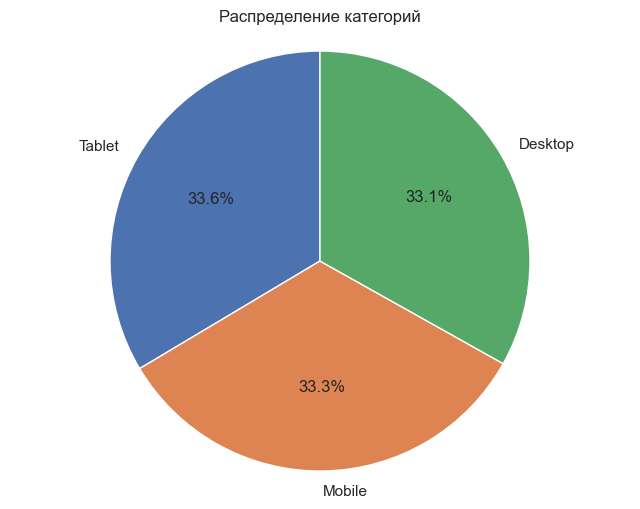

In [27]:
counts = explore['device_type'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение категорий')
plt.axis('equal')  
plt.show()

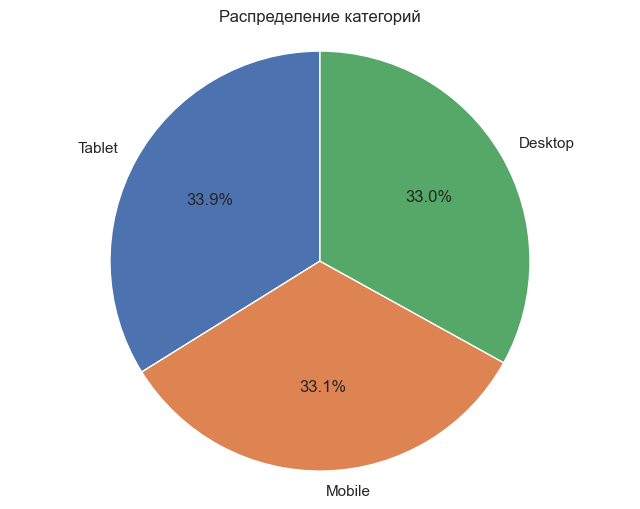

In [28]:
counts = explore[explore['is_fraud'] == 1]['device_type'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение категорий')
plt.axis('equal') 
plt.show()

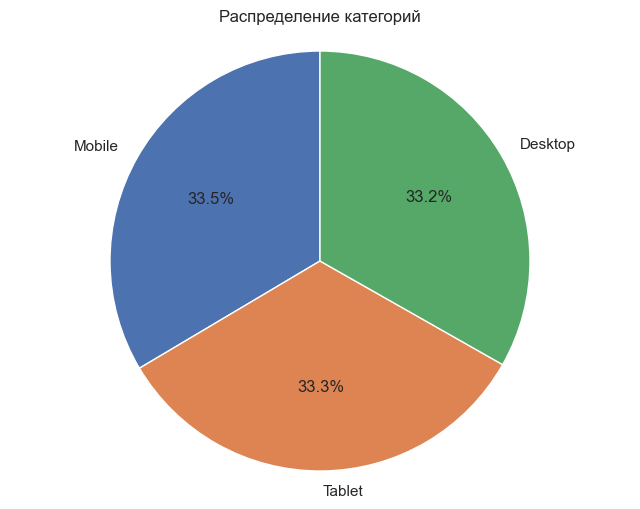

In [29]:
counts = explore[explore['is_fraud'] == 0]['device_type'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение категорий')
plt.axis('equal')  
plt.show()

Графики идентичны при любых условиях:
1. Для всех записей;
2. Для легитиминых записей;
3. Для мошеннических записей.

Итого, получаем следующую картину: любая легитимная запись имеет amount < 1000 и никак не привязана к device_type. Любая мошенническая транзакция имеет amount > 1000 и никак не связана с device_type.

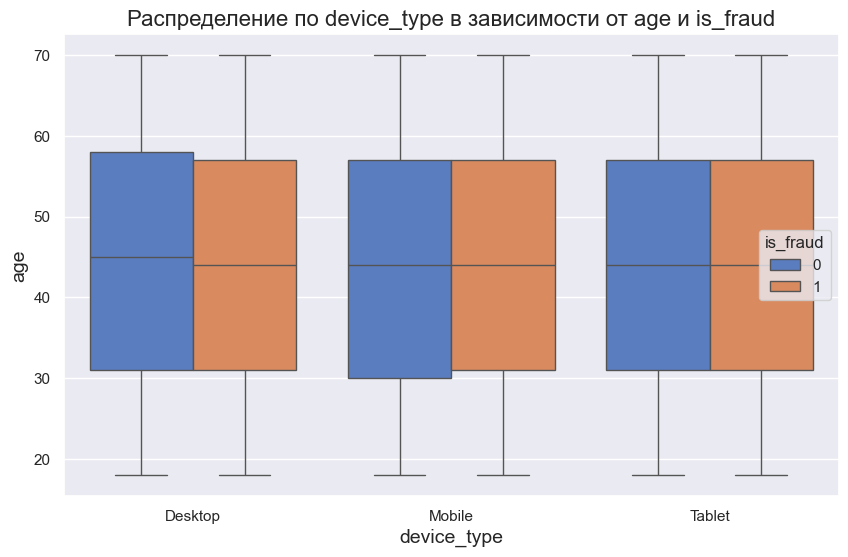

In [31]:
boxplot_visual(explore, 'device_type', 'age')

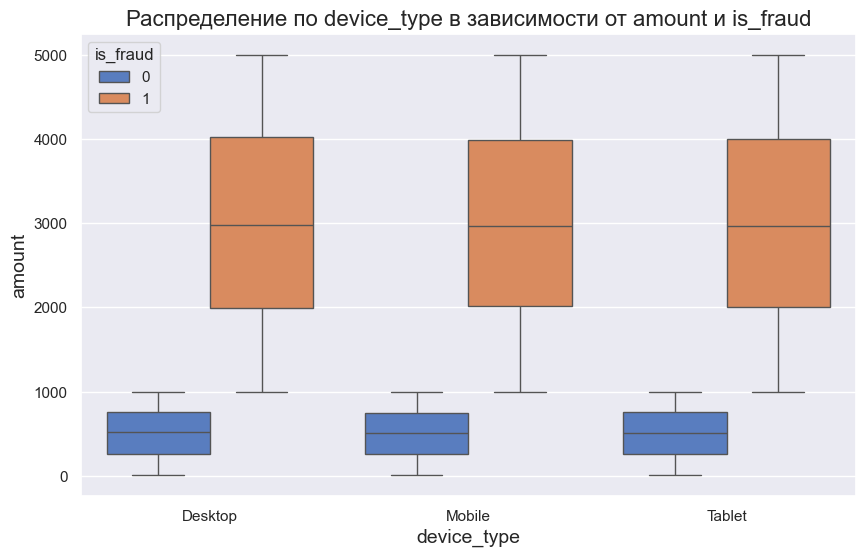

In [32]:
boxplot_visual(explore, 'device_type', 'amount')

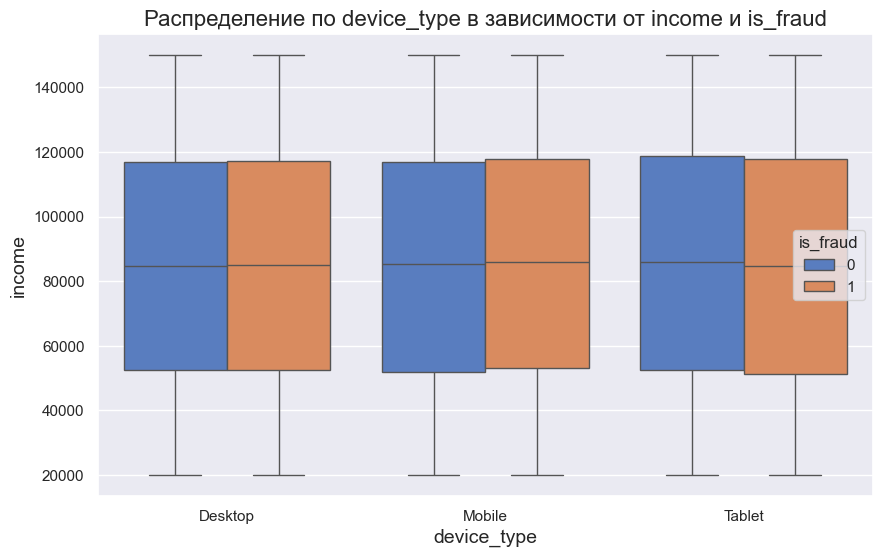

In [33]:
boxplot_visual(explore, 'device_type', 'income')

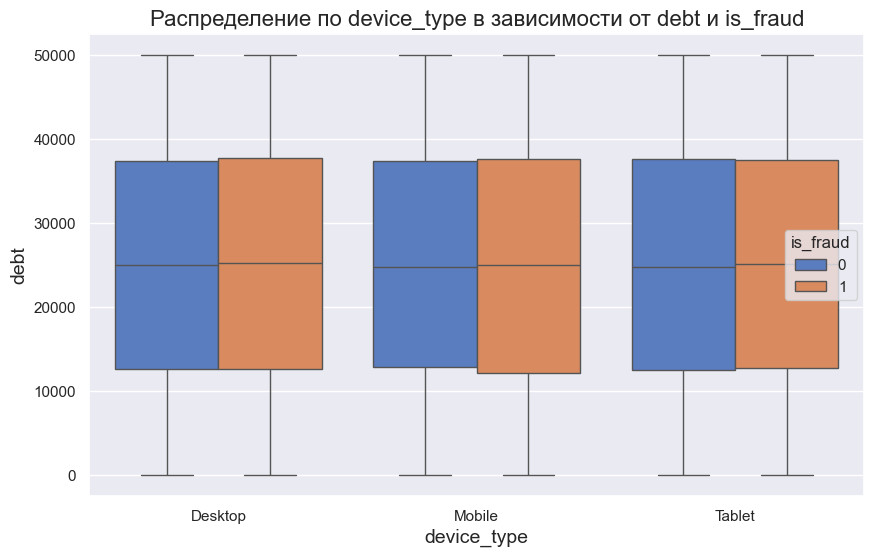

In [34]:
boxplot_visual(explore, 'device_type', 'debt')

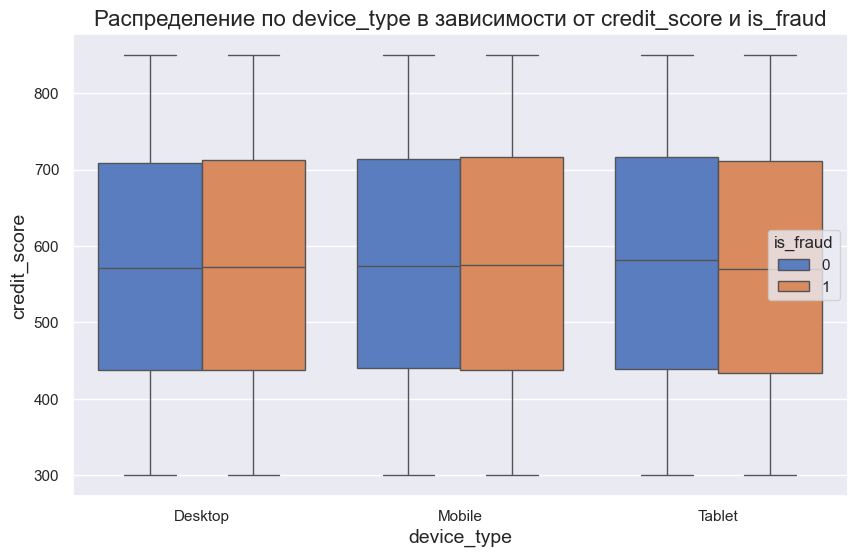

In [35]:
boxplot_visual(explore, 'device_type', 'credit_score')

Видна все та же картина: amount < 1000 не свойственен мошенническим транзакциям. <br>
В остальном же, тяжело выделить какие-либо закономерности. Незначительные различия. Точно можно сказать, что никак не влияет device_type и зависимости у этого признака с другими нет.

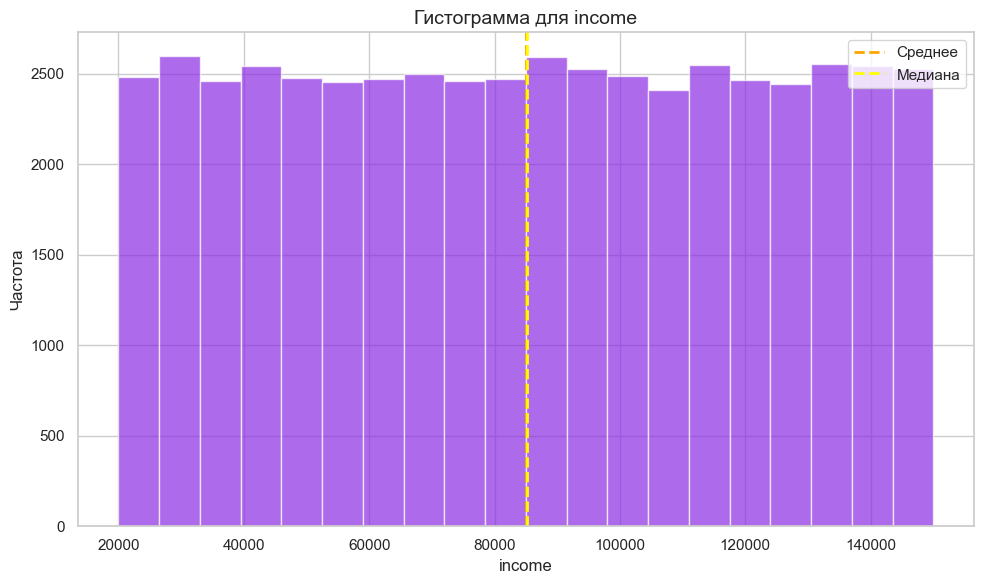

In [37]:
hist_visual(explore, 'income')

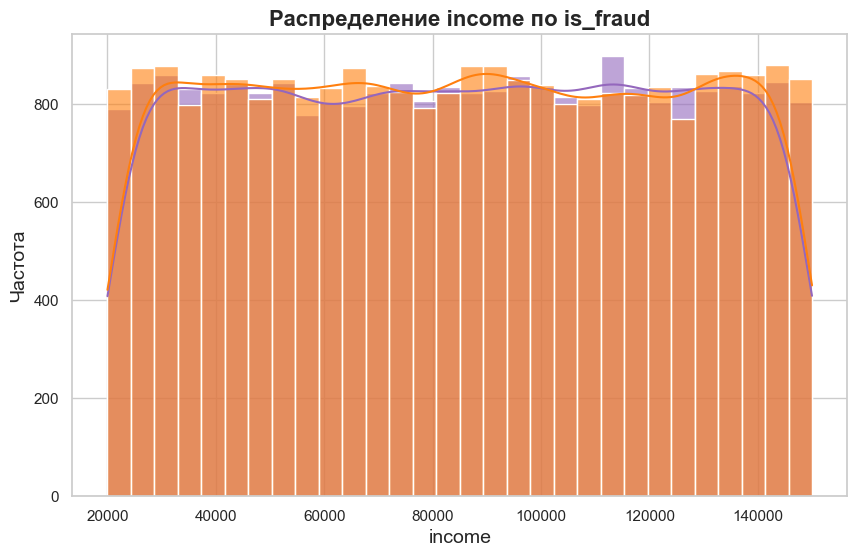

In [38]:
fog(explore, 'income')

Нельзя сказать о какой-то значительной зависимости.

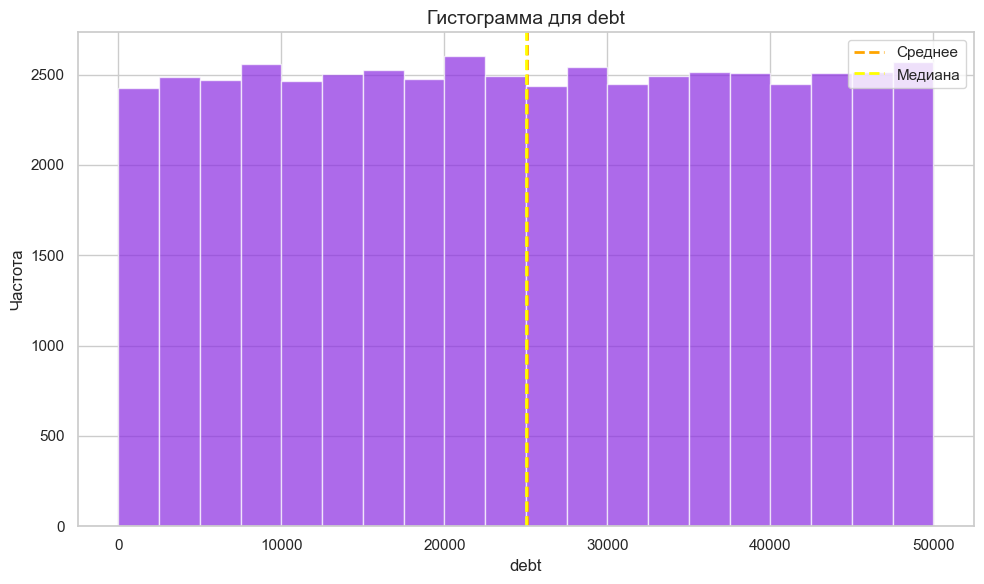

In [40]:
hist_visual(explore, 'debt')

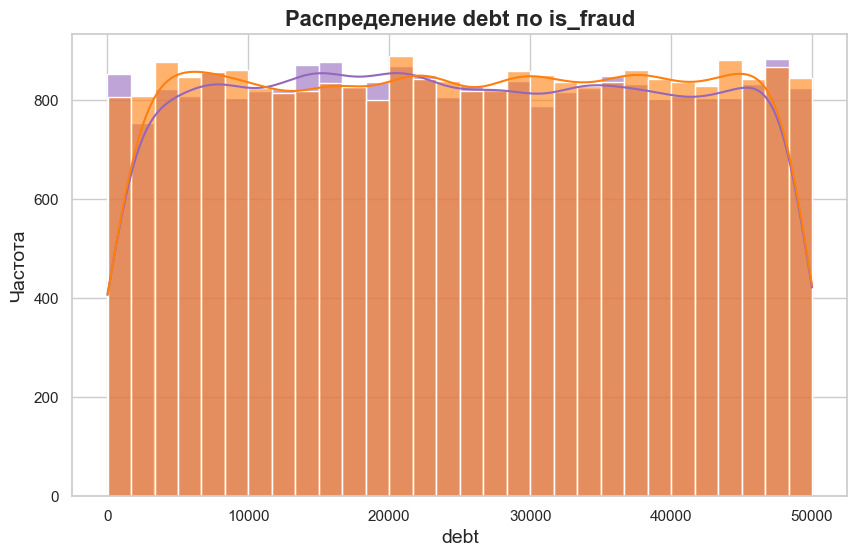

In [41]:
fog(explore, 'debt')

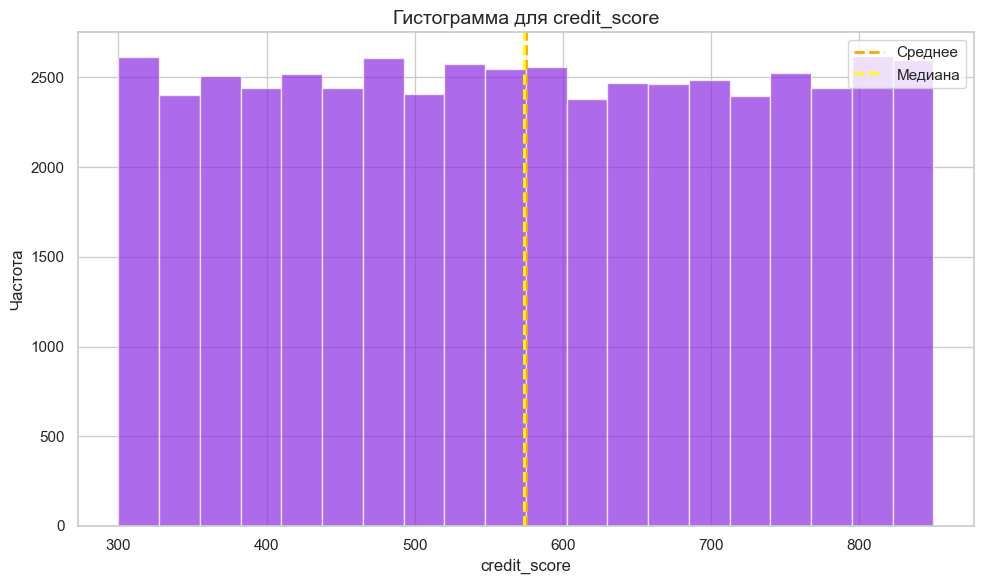

In [42]:
hist_visual(explore, 'credit_score')

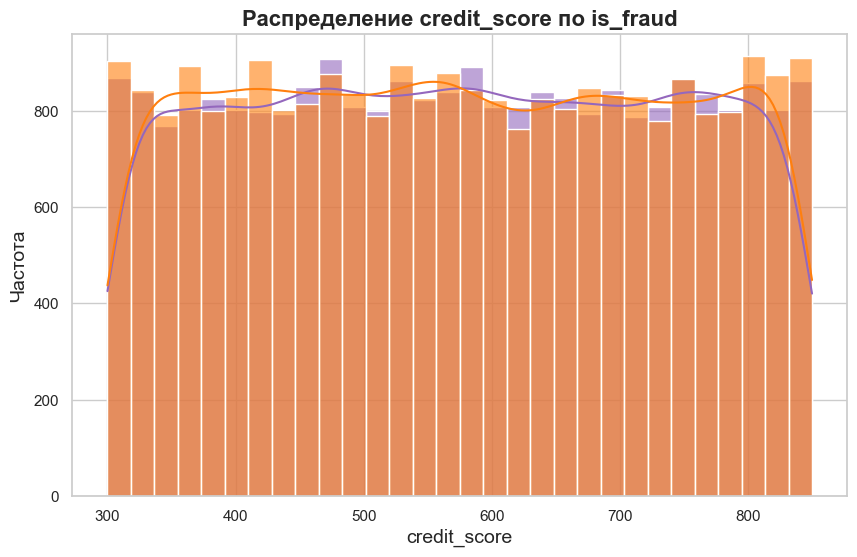

In [43]:
fog(explore, 'credit_score')

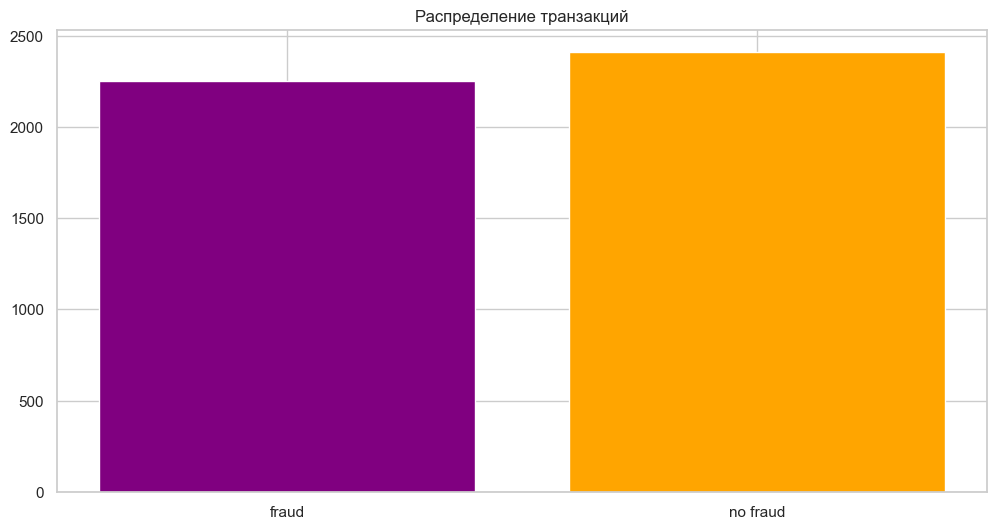

In [44]:
filtered_df_1 = explore[explore['credit_score'] > 800]
count_fraud_1 = filtered_df_1[filtered_df_1['is_fraud'] == 1].shape[0]
count_fraud_0 = filtered_df_1[filtered_df_1['is_fraud'] == 0].shape[0]
outcomes = [count_fraud_0, count_fraud_1]
labels = ['fraud', 'no fraud']

plt.figure(figsize=(12, 6))
plt.bar(labels, outcomes, color=['purple', 'orange'])
plt.title('Распределение транзакций')
plt.show()

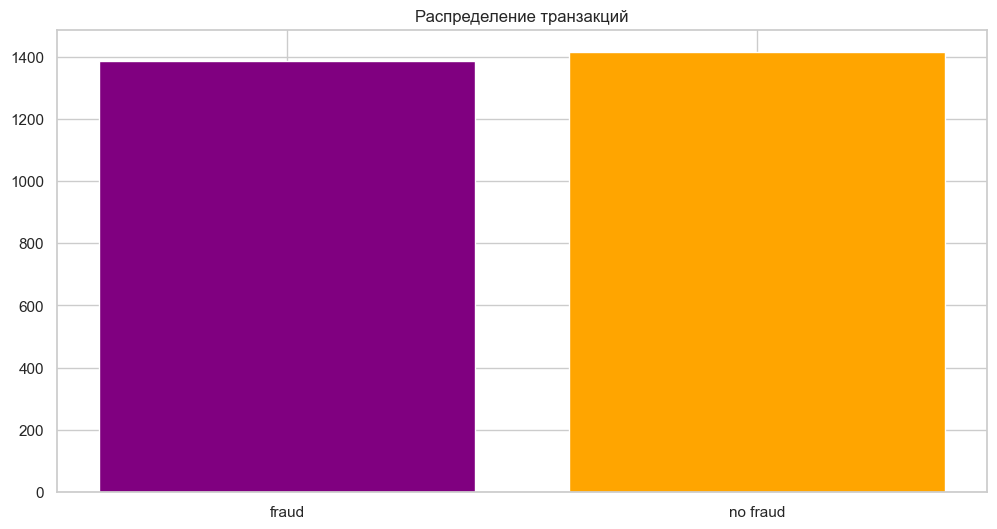

In [45]:
filtered_df_1 = explore[explore['credit_score'] < 330]
count_fraud_1 = filtered_df_1[filtered_df_1['is_fraud'] == 1].shape[0]
count_fraud_0 = filtered_df_1[filtered_df_1['is_fraud'] == 0].shape[0]
outcomes = [count_fraud_0, count_fraud_1]
labels = ['fraud', 'no fraud']

plt.figure(figsize=(12, 6))
plt.bar(labels, outcomes, color=['purple', 'orange'])
plt.title('Распределение транзакций')
plt.show()

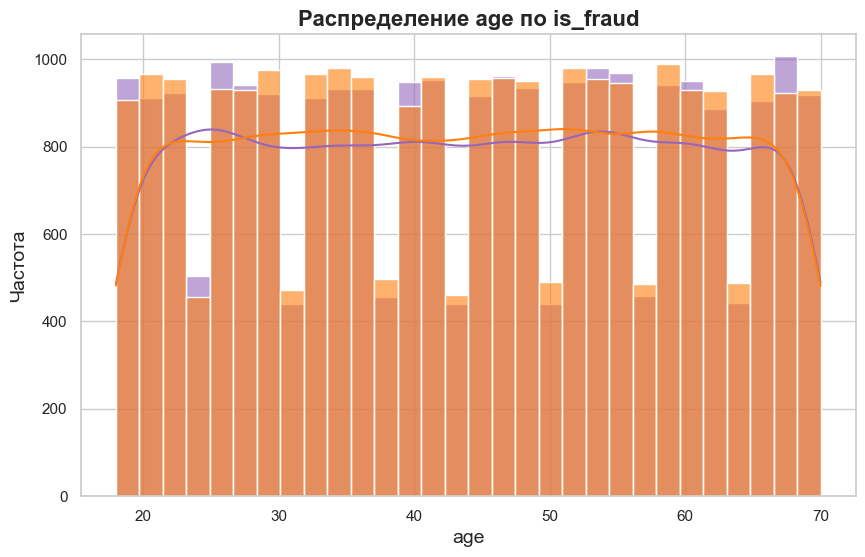

In [46]:
fog(explore, 'age')

In [47]:
len(explore['location'].unique())

25195

В категориальном признаке location 25195 уникальных значений. Это слишком много для какого-либо анализа признака. Никак разбить на группы по взаимосвязи мы не можем.

In [49]:
explore

,timestamp,user_id,amount,location,device_type,is_fraud,age,income,debt,credit_score
1828401,2023-08-10 19:45:13,88e4edff-70ec-48e2-98fc-e2158bda39ce,2820.81,East Ginashire,Desktop,1,61,109941.13,26723.01,445
1200071,2023-04-24 18:48:52,d0b2cf73-ae9c-427a-b91b-154868254738,3074.92,Lake Michelehaven,Mobile,1,52,77270.96,4145.25,320
194849,2023-09-11 22:09:37,53bcc7b9-4c8f-4c69-adf6-a6888431b7ba,176.97,West Sandrafurt,Desktop,0,26,127563.16,11420.89,397
1629054,2023-11-26 13:43:40,f623ca05-ec15-400d-b85d-9dcb99d6677e,3528.71,Randallbury,Desktop,1,47,124594.27,18794.04,819
191144,2023-12-06 05:50:28,16d63788-6ef5-49ac-81f6-cda2e182043f,629.59,Port Casey,Desktop,0,19,139644.01,3172.29,573
...,...,...,...,...,...,...,...,...,...,...
815830,2023-06-17 15:34:49,e14298de-c96d-4ba0-b67a-ba9f6bcc896c,554.45,Davisborough,Mobile,0,34,29943.57,42442.61,697
1413582,2023-11-16 17:09:10,55ce8261-aa1a-4481-bf8d-ea8f870d61d2,4389.95,Jamesmouth,Mobile,1,66,57108.91,10198.95,360
722058,2023-08-09 21:24:18,5109b672-e75d-4fc3-af5a-85b0017e45d8,564.65,Lake Tanyaview,Desktop,0,28,129418.02,7108.29,577
948395,2023-04-09 18:48:11,1e292691-81f7-4a59-9b6f-3f626cfd103b,146.11,Port Patriciaton,Desktop,0,22,62650.69,48990.38,398


In [50]:
feature_analysis(explore, 'income')

Признак income
#=#=#=#=#=#=#=#=#=#
Минимальное значение: 20007.66
#=#=#=#=#=#=#=#=#=#
Среднее значение: 85041.802688
#=#=#=#=#=#=#=#=#=#
Максимальное значение: 149999.67
#=#=#=#=#=#=#=#=#=#
Медиана: 85218.47
#=#=#=#=#=#=#=#=#=#
Ассиметрия: -0.000648510235840861
#=#=#=#=#=#=#=#=#=#
Дисперсия: 1414069058.2770584
#=#=#=#=#=#=#=#=#=#
Эксцесс: -1.2040655585607303
#=#=#=#=#=#=#=#=#=#


In [51]:
feature_analysis(explore, 'debt')

Признак debt
#=#=#=#=#=#=#=#=#=#
Минимальное значение: 0.15
#=#=#=#=#=#=#=#=#=#
Среднее значение: 25056.001488799997
#=#=#=#=#=#=#=#=#=#
Максимальное значение: 49999.81
#=#=#=#=#=#=#=#=#=#
Медиана: 24994.395
#=#=#=#=#=#=#=#=#=#
Ассиметрия: 0.0013167146696000534
#=#=#=#=#=#=#=#=#=#
Дисперсия: 208140266.8303392
#=#=#=#=#=#=#=#=#=#
Эксцесс: -1.199066352546247
#=#=#=#=#=#=#=#=#=#


In [52]:
feature_analysis(explore, 'credit_score')

Признак credit_score
#=#=#=#=#=#=#=#=#=#
Минимальное значение: 300
#=#=#=#=#=#=#=#=#=#
Среднее значение: 575.08682
#=#=#=#=#=#=#=#=#=#
Максимальное значение: 850
#=#=#=#=#=#=#=#=#=#
Медиана: 574.0
#=#=#=#=#=#=#=#=#=#
Ассиметрия: 0.004396091752034083
#=#=#=#=#=#=#=#=#=#
Дисперсия: 25402.94968228763
#=#=#=#=#=#=#=#=#=#
Эксцесс: -1.1984997329814844
#=#=#=#=#=#=#=#=#=#


In [53]:
explore = explore.assign(AoN='')
explore.loc[explore['amount'] < 1000, 'AoN'] = 0
explore.loc[~(explore['amount'] < 1000), 'AoN'] = 1
explore['AoN'] = explore['AoN'].astype(int)

In [54]:
explore.head()

,timestamp,user_id,amount,location,device_type,is_fraud,age,income,debt,credit_score,AoN
1828401,2023-08-10 19:45:13,88e4edff-70ec-48e2-98fc-e2158bda39ce,2820.81,East Ginashire,Desktop,1,61,109941.13,26723.01,445,1
1200071,2023-04-24 18:48:52,d0b2cf73-ae9c-427a-b91b-154868254738,3074.92,Lake Michelehaven,Mobile,1,52,77270.96,4145.25,320,1
194849,2023-09-11 22:09:37,53bcc7b9-4c8f-4c69-adf6-a6888431b7ba,176.97,West Sandrafurt,Desktop,0,26,127563.16,11420.89,397,0
1629054,2023-11-26 13:43:40,f623ca05-ec15-400d-b85d-9dcb99d6677e,3528.71,Randallbury,Desktop,1,47,124594.27,18794.04,819,1
191144,2023-12-06 05:50:28,16d63788-6ef5-49ac-81f6-cda2e182043f,629.59,Port Casey,Desktop,0,19,139644.01,3172.29,573,0


<h3>Подготовка данных и обучение</h3>

In [56]:
explore['AoN'].isna().sum()

0

In [57]:
explore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 1828401 to 1698948
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     50000 non-null  object 
 1   user_id       50000 non-null  object 
 2   amount        50000 non-null  float64
 3   location      50000 non-null  object 
 4   device_type   50000 non-null  object 
 5   is_fraud      50000 non-null  int64  
 6   age           50000 non-null  int64  
 7   income        50000 non-null  float64
 8   debt          50000 non-null  float64
 9   credit_score  50000 non-null  int64  
 10  AoN           50000 non-null  int32  
dtypes: float64(3), int32(1), int64(3), object(4)
memory usage: 4.4+ MB


In [58]:
explore.drop('user_id', axis=1, inplace=True)

In [59]:
explore.drop('timestamp', axis=1, inplace=True)

In [60]:
explore.isna().sum()

amount          0
location        0
device_type     0
is_fraud        0
age             0
income          0
debt            0
credit_score    0
AoN             0
dtype: int64

In [61]:
target = 'is_fraud'
numerical_cols = ['amount', 'age', 'income', 'debt', 'credit_score']
categorical_cols = ['location', 'device_type', 'AoN']

# Сохраняем целевую переменную
y = explore[target]

In [62]:
# Кодируем категориальные переменные
le = LabelEncoder()
for col in categorical_cols:
    explore[col] = le.fit_transform(explore[col])

In [63]:
explore

,amount,location,device_type,is_fraud,age,income,debt,credit_score,AoN
1828401,2820.81,3963,0,1,61,109941.13,26723.01,445,1
1200071,3074.92,9619,1,1,52,77270.96,4145.25,320,1
194849,176.97,24537,0,0,26,127563.16,11420.89,397,0
1629054,3528.71,18461,0,1,47,124594.27,18794.04,819,1
191144,629.59,16745,0,0,19,139644.01,3172.29,573,0
...,...,...,...,...,...,...,...,...,...
815830,554.45,2786,1,0,34,29943.57,42442.61,697,0
1413582,4389.95,7124,1,1,66,57108.91,10198.95,360,1
722058,564.65,10036,0,0,28,129418.02,7108.29,577,0
948395,146.11,17838,0,0,22,62650.69,48990.38,398,0


In [64]:
# Масштабируем числовые переменные
scaler = StandardScaler()
scaled = scaler.fit_transform(explore[numerical_cols])
scaled = pd.DataFrame(scaled, columns=numerical_cols)

In [65]:
scaled

,amount,age,income,debt,credit_score
0,0.704275,1.112976,0.662144,0.115547,-0.816190
1,0.873269,0.523757,-0.206649,-1.449411,-1.600464
2,-1.053994,-1.178429,1.130764,-0.945106,-1.117351
3,1.175059,0.196414,1.051812,-0.434043,1.530359
4,-0.752982,-1.636710,1.452028,-1.516851,-0.013093
...,...,...,...,...,...
49995,-0.802953,-0.654679,-1.465218,1.205138,0.764907
49996,1.747821,1.440319,-0.742815,-1.029804,-1.349496
49997,-0.796170,-1.047491,1.180090,-1.244030,0.012004
49998,-1.074517,-1.440303,-0.595443,1.658991,-1.111077


In [66]:
# Удаляем числовые переменные из исходного датафрейма
explore = explore.drop(columns=numerical_cols, axis=1)

# Объединяем датафреймы
explore = pd.concat([explore.reset_index(drop=True), scaled.reset_index(drop=True)], axis=1)

In [67]:
explore

,location,device_type,is_fraud,AoN,amount,age,income,debt,credit_score
0,3963,0,1,1,0.704275,1.112976,0.662144,0.115547,-0.816190
1,9619,1,1,1,0.873269,0.523757,-0.206649,-1.449411,-1.600464
2,24537,0,0,0,-1.053994,-1.178429,1.130764,-0.945106,-1.117351
3,18461,0,1,1,1.175059,0.196414,1.051812,-0.434043,1.530359
4,16745,0,0,0,-0.752982,-1.636710,1.452028,-1.516851,-0.013093
...,...,...,...,...,...,...,...,...,...
49995,2786,1,0,0,-0.802953,-0.654679,-1.465218,1.205138,0.764907
49996,7124,1,1,1,1.747821,1.440319,-0.742815,-1.029804,-1.349496
49997,10036,0,0,0,-0.796170,-1.047491,1.180090,-1.244030,0.012004
49998,17838,0,0,0,-1.074517,-1.440303,-0.595443,1.658991,-1.111077


In [68]:
explore['is_fraud'].unique()

array([1, 0], dtype=int64)

In [69]:
X = explore.drop('is_fraud', axis=1)

In [70]:
X.shape

(50000, 8)

In [71]:
y.shape

(50000,)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [73]:
X_train

,location,device_type,AoN,amount,age,income,debt,credit_score
27434,21099,0,1,0.844865,1.374850,0.456349,1.724196,1.210375
13400,24778,1,0,-0.999414,-0.523742,1.137433,0.876050,1.593100
883,21266,2,0,-0.837755,-0.392804,0.456221,-0.581718,1.718584
7303,19147,0,0,-0.903893,-1.571241,-1.478015,-1.216433,-1.023238
45124,4899,1,1,1.143203,0.130945,0.130568,-1.323207,1.442520
...,...,...,...,...,...,...,...,...
11284,22769,0,1,-0.431699,-0.196398,-1.481427,1.546306,0.513939
44732,4467,0,0,-0.645225,0.261883,1.447838,-0.281308,0.978230
38158,11437,0,0,-0.729911,1.702194,-0.110275,1.260550,-1.493803
860,5244,1,1,1.353703,1.571257,1.260194,-1.610239,0.783729


In [74]:
y_test.unique()

array([0, 1], dtype=int64)

In [75]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predict_lr = lr.predict(X_test)

1.0


In [77]:
accuracy = accuracy_score(y_test, predict_lr)
conf_matrix = confusion_matrix(y_test, predict_lr)
classification_rep = classification_report(y_test, predict_lr)

In [87]:
print(f'Accuracy: {accuracy}')
print(f'Confusion matrix:')
print(f'{conf_matrix[0]}')
print(f'{conf_matrix[1]}')
print(classification_rep)

Accuracy: 1.0
Confusion matrix:
[6169    0]
[   0 6331]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6169
           1       1.00      1.00      1.00      6331

    accuracy                           1.00     12500
   macro avg       1.00      1.00      1.00     12500
weighted avg       1.00      1.00      1.00     12500



<h3>Заключение</h3>

В рамках проведённого анализа синтетического датасета по обнаружению мошенничества с кредитами были реализованы следующие этапы работы:

- Проанализированы и визуализированы все признаки с помощью графиков рассеивания и гистограмм, что позволило оценить особенности распределения данных.
- Проведена проверка датасета на наличие дубликатов и пропущенных значений. Выявлено, что данные полной и чистые, отсутствуют пропуски и дубликаты.
- Были построены и обучены модели машинного обучения, в частности, RandomForestClassifier, который показал идеальное значение accuracy = 1. Это объясняется синтетической природой датасета и тем, что одна из характеристик данных позволяет однозначно отличать мошеннические операции от немошеннических.
- Выявлена ключевая зависимость, обусловливающая максимальную важность одного из признаков. Эта особенность делает классификацию в данном датасете тривиальной.

Несмотря на успешное техническое применение алгоритмов и отличный результат классификации, стоит отметить, что подобные итоги невозможны на реальных данных из-за отсутствия ярко выраженной однозначной зависимости между признаками и целевой переменной. Данный проект иллюстрирует важность оценки качества и природы исходного набора данных перед применением моделей машинного обучения, а также необходимость тестирования решений на реальных, а не синтетических примерах.